[참고 사이트](https://wikidocs.net/24682)
# 3) 개체명 인식
## 2. NLTK를 이용한 개체명 인식(NER using NTLK)

In [75]:
!pip install nltk
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [76]:
from nltk import word_tokenize, pos_tag, ne_chunk
sentence = "Bob have a nice boyfriend in London"
sentence = pos_tag(word_tokenize(sentence))
sentence

[('Bob', 'NNP'),
 ('have', 'VBP'),
 ('a', 'DT'),
 ('nice', 'JJ'),
 ('boyfriend', 'NN'),
 ('in', 'IN'),
 ('London', 'NNP')]

- ne_chunk는 개체명을 태깅하기 위해서 앞서 품사 태깅이 수행되어야 함!

In [77]:
sentence = ne_chunk(sentence)
sentence

TclError: ignored

Tree('S', [Tree('PERSON', [('Bob', 'NNP')]), ('have', 'VBP'), ('a', 'DT'), ('nice', 'JJ'), ('boyfriend', 'NN'), ('in', 'IN'), Tree('GPE', [('London', 'NNP')])])

# 4) 개체명 인식의 BIO 표현 이해하기
### 도메인 또는 목적에 특화되도록 개체명 인식을 정확하게 하는 방법
- 기존에 공개된 개체명 인식기 사용x
- 직접 목적에 맞는 데이터를 준비하여 기계를 훈련시켜 모델을 만드는 방법

### 양방향 LSTM을 이용해서 개체명 인식기를 만들어보자

## 2. 개체명 인식 데이터 이해하기
- 사용데이터 : [CONLL2003](https://raw.githubusercontent.com/Franck-Dernoncourt/NeuroNER/master/neuroner/data/conll2003/en/train.txt)


In [78]:
!wget https://raw.githubusercontent.com/Franck-Dernoncourt/NeuroNER/master/neuroner/data/conll2003/en/train.txt

--2021-04-13 02:22:00--  https://raw.githubusercontent.com/Franck-Dernoncourt/NeuroNER/master/neuroner/data/conll2003/en/train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3283420 (3.1M) [text/plain]
Saving to: ‘train.txt.2’

train.txt.2         100%[===================>]   3.13M  --.-KB/s    in 0.1s    

2021-04-13 02:22:00 (30.3 MB/s) - ‘train.txt.2’ saved [3283420/3283420]



In [79]:
from google.colab import files
#files.download('train.txt')

### 데이터 형식
- word / pos tagging / chunk tagging / ner tagging

In [80]:
f = open('train.txt')
f.readlines()[:20]

['-DOCSTART- -X- -X- O\n',
 '\n',
 'EU NNP B-NP B-ORG\n',
 'rejects VBZ B-VP O\n',
 'German JJ B-NP B-MISC\n',
 'call NN I-NP O\n',
 'to TO B-VP O\n',
 'boycott VB I-VP O\n',
 'British JJ B-NP B-MISC\n',
 'lamb NN I-NP O\n',
 '. . O O\n',
 '\n',
 'Peter NNP B-NP B-PER\n',
 'Blackburn NNP I-NP I-PER\n',
 '\n',
 'BRUSSELS NNP B-NP B-LOC\n',
 '1996-08-22 CD I-NP O\n',
 '\n',
 'The DT B-NP O\n',
 'European NNP I-NP B-ORG\n']

## 3. 데이터 전처리하기
- bi-LSTM 을 이용해서 개체명 인식 태깅을 하는 모델을 만들어보자


In [81]:
import re
%matplotlib inline
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

In [82]:
# raw data 전처리
train_set = 'train.txt'
tagged_sentences = []
sentence = []

In [83]:
with open(train_set, 'r') as f:
  for line in f.readlines():
    if len(line) == 0 or line.startswith('-DOCSTART') or line[0] == '\n':
      if len(sentence) > 0 :
        tagged_sentences.append(sentence)
        sentence = []
      continue
    splits = line.split(' ') 
    splits[-1] = splits[-1][:-1] # same as 're.sub(r'\n', '', splits[-1])'
    word = splits[0].lower()
    sentence.append([word, splits[-1]]) # 단어와 개체명 태깅만 기록

In [84]:
# tagged_sentences[n][m] , n == 14041
len(tagged_sentences)

14041

In [85]:
tagged_sentences[0]

[['eu', 'B-ORG'],
 ['rejects', 'O'],
 ['german', 'B-MISC'],
 ['call', 'O'],
 ['to', 'O'],
 ['boycott', 'O'],
 ['british', 'B-MISC'],
 ['lamb', 'O'],
 ['.', 'O']]

### sentence, ner_tag분리
- zip()함수 사용

In [86]:
sentences,  ner_tags = [], []
for tagged_sentence in tagged_sentences:
  sentence, tag_info = zip(*tagged_sentence)
  sentences.append(list(sentence))
  ner_tags.append(list(tag_info))

In [87]:
print(sentences[100])
print(ner_tags[100])

['rabinovich', 'is', 'winding', 'up', 'his', 'term', 'as', 'ambassador', '.']
['B-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


### 14,041개의 문장 샘플 길이 확인
- 전체 데이터의 길이 분포
- map(func, iterator) : iterator 결과에 각각 func을 적용하여 반환값 도출

In [88]:
print('maximum length of samples : %d' % max(len(l) for l in sentences))
print('average length of samples : %f' % (sum(map(len, sentences)) /len(sentences)))

maximum length of samples : 113
average length of samples : 14.501887


Text(0, 0.5, 'number of samples')

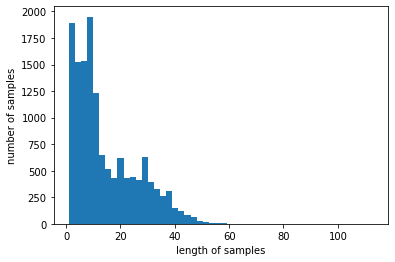

In [89]:
plt.hist([len(s) for s in sentences], bins = 50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')

- 케라스 토크나이저를 통해서 토큰화와 정수 인코딩 진행
- 문장 데이터 안의 모든 단어를 사용하지 않고 높은 빈도수를 가진 상위 약 4000개 단어만 사용

### Keras Tokenizer
- text corpus를 벡터화하는 class
- fit_on_texts(sentences) : 내부 vocab을 sentence기반으로 업데이트 하는 함수
- texts_to_sequences(texts) : texts안의 각 text를 정수 시퀀스 형태로 바꾸어주는 함수

In [90]:
help(Tokenizer)

Help on class Tokenizer in module keras_preprocessing.text:

class Tokenizer(builtins.object)
 |  Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', char_level=False, oov_token=None, document_count=0, **kwargs)
 |  
 |  Text tokenization utility class.
 |  
 |  This class allows to vectorize a text corpus, by turning each
 |  text into either a sequence of integers (each integer being the index
 |  of a token in a dictionary) or into a vector where the coefficient
 |  for each token could be binary, based on word count, based on tf-idf...
 |  
 |  # Arguments
 |      num_words: the maximum number of words to keep, based
 |          on word frequency. Only the most common `num_words-1` words will
 |          be kept.
 |      filters: a string where each element is a character that will be
 |          filtered from the texts. The default is all punctuation, plus
 |          tabs and line breaks, minus the `'` character.
 |      lower: boolean

In [91]:
max_words = 4000

# src : sentences -> trg : ner tags
src_tokenizer = Tokenizer(num_words = max_words, oov_token='OOV')
src_tokenizer.fit_on_texts(sentences)

tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(ner_tags)

In [92]:
vocab_size = max_words
tag_size = len(tar_tokenizer.word_index) + 1

print('단어 집합의 크기 : {}'.format(vocab_size))
print('개체명 태깅 정보 집합의 크기 : {}'.format(tag_size))

단어 집합의 크기 : 4000
개체명 태깅 정보 집합의 크기 : 10


In [93]:
# 정수 인코딩 수행
X_train = src_tokenizer.texts_to_sequences(sentences)
Y_train = tar_tokenizer.texts_to_sequences(ner_tags)

In [94]:
X_train[0], Y_train[0]

([989, 1, 205, 629, 7, 3939, 216, 1, 3], [4, 1, 7, 1, 1, 1, 7, 1, 1])

In [95]:
# 현재 문장 데이터에 대해서는 일부 단어가 'OOV'로 대체된 상황이므로
# 이를 확인하기 위해 다시 디코딩 작업 실시
index_to_word = src_tokenizer.index_word
index_to_ner = tar_tokenizer.index_word

In [96]:
# 정수 인코딩 된 문장을 다시 디코딩 해보기
decoded = []
for idx in X_train[0]:
  decoded.append(index_to_word[idx])

print('기존 문장 {}'.format(sentences[0]))
print('빈도수가 낮은 단어가 OOV 처리된 문장 : {}'.format(decoded))

기존 문장 ['eu', 'rejects', 'german', 'call', 'to', 'boycott', 'british', 'lamb', '.']
빈도수가 낮은 단어가 OOV 처리된 문장 : ['eu', 'OOV', 'german', 'call', 'to', 'boycott', 'british', 'OOV', '.']


In [97]:
# 앞서 본 그래프에 따르면 대부분의 샘플 길이가 70 이내 이므로
# X_train, Y_train 샘플들의 모든 길이를 임의오 70 정도로 맞추어 보기
max_len = 70

# 모든 샘플들의 길이를 맞출 때 뒤의 공간에 숫자 0으로 채움
X_train = pad_sequences(X_train, padding = 'post', maxlen = max_len)
Y_train = pad_sequences(Y_train, padding = 'post', maxlen = max_len)

In [98]:
# train : test  = 8 : 2
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size = .2, random_state = 777)

In [99]:
# 레이블에 해당하는 태깅 정보에 대해서 one-hot encoding 수행
Y_train = to_categorical(Y_train, num_classes=tag_size)
Y_test = to_categorical(Y_test, num_classes=tag_size)

In [100]:
print('훈련 샘플 문장의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(Y_train.shape))
print('테스트 샘플 문장의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(Y_test.shape))

훈련 샘플 문장의 크기 : (11232, 70)
훈련 샘플 레이블의 크기 : (11232, 70, 10)
테스트 샘플 문장의 크기 : (2809, 70)
테스트 샘플 레이블의 크기 : (2809, 70, 10)


## 4. 양방향 LSTM(Bi-directional LSTM)으로 개체명 인식기 만들기
- Embedding layer 추가  
: 각 데이터의 길이가 달라서 패딩을 하느라 숫자 0이 많아 졌으므로 숫자 0은 연산에서 제외시키는 옵션은 mask_zero = True 추가
- Bidirectional LSTM layer 추가   
: n-n 문제이므로 return_sequences = True임
- TimeDistributed layer 추가

In [101]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional, TimeDistributed
from keras.optimizers import Adam

In [102]:
#help(Embedding)
#help(Bidirectional)
#help(TimeDistributed)

In [103]:
# 모델 설계를 위한 도구 임포트
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=128, input_length=max_len, mask_zero=True))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(TimeDistributed(Dense(tag_size, activation='softmax')))

In [104]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])

In [105]:
X_train.shape, Y_train.shape,  X_test.shape, Y_test.shape

((11232, 70), (11232, 70, 10), (2809, 70), (2809, 70, 10))

In [106]:
model.fit(X_train, Y_train, batch_size=128, epochs=8,  validation_data=(X_test, Y_test))

Epoch 1/8
88/88 [==============================] - 40s 53ms/step - loss: 0.2559 - accuracy: 0.7941 - val_loss: 0.1240 - val_accuracy: 0.8335
Epoch 2/8
88/88 [==============================] - 3s 29ms/step - loss: 0.1134 - accuracy: 0.8432 - val_loss: 0.0738 - val_accuracy: 0.8908
Epoch 3/8
88/88 [==============================] - 2s 28ms/step - loss: 0.0687 - accuracy: 0.8996 - val_loss: 0.0545 - val_accuracy: 0.9217
Epoch 4/8
88/88 [==============================] - 2s 28ms/step - loss: 0.0484 - accuracy: 0.9318 - val_loss: 0.0404 - val_accuracy: 0.9441
Epoch 5/8
88/88 [==============================] - 3s 29ms/step - loss: 0.0363 - accuracy: 0.9493 - val_loss: 0.0352 - val_accuracy: 0.9510
Epoch 6/8
88/88 [==============================] - 3s 29ms/step - loss: 0.0292 - accuracy: 0.9584 - val_loss: 0.0335 - val_accuracy: 0.9537
Epoch 7/8
88/88 [==============================] - 2s 28ms/step - loss: 0.0256 - accuracy: 0.9643 - val_loss: 0.0318 - val_accuracy: 0.9547
Epoch 8/8
88/88 [==

In [111]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, Y_test)[1]))

88/88 [==============================] - 1s 7ms/step - loss: 0.0313 - accuracy: 0.9572

 테스트 정확도: 0.9572


In [116]:
i = 10  # 확인하고 싶은 테스트용 샘플의 인덱스
y_predicted = model.predict(np.array([X_test[i]]))
y_predicted = np.argmax(y_predicted, axis = -1)
true = np.argmax(Y_test[i], -1)

print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
print(35 * "-")

for w, t, pred in zip(X_test[i], true, y_predicted[0]):
    if w != 0: # PAD값은 제외함.
        print("{:17}: {:7} {}".format(index_to_word[w], index_to_ner[t].upper(), index_to_ner[pred].upper()))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x7fe37dab6d40>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function Model.make_predict_function.<locals>.predict_function at 0x7fe37dab6d40>. No

- 해당 방법은 정확한 정확도 계산 방법은 아님
- O가 태깅된 상황에서 예측 정확도가 수만은 O로 결정되고 있기 때문
- F1-score를 도입하면 정확도를 좀 더 잘 확인할 수 있음